In [1]:
import xarray as xr
import numpy as np
import s3fs
from skimage import measure, feature
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Download dataset
Download netcdf dataset from imos-data/IMOS/SOOP/SOOP-BA/VLMJ_Investigator/

In [2]:
# do NOT include "s3-ap-southeast-2.amazonaws.com/" in the bucket path name
bucket_path = "imos-data/IMOS/SOOP/SOOP-BA/VLMJ_Investigator/Investigator_20160412-20160414/"
filename = "IMOS_SOOP-BA_AE_20160412T031347Z_VLMJ_FV02_Investigator-EK60-18_END-20160414T043251Z_C-20210622T061448Z.nc"

fs = s3fs.S3FileSystem(anon=True) # access server anonymously i.e. with no user credentials
fileObj = fs.open(bucket_path+filename) # create an s3 file system object

print(fileObj.size) # (optional) confirm that object points to existing file and check size of download

155373374


In [3]:
ds = xr.open_dataset(fileObj)
ds

<xarray.Dataset>
Dimensions:                                                (DEPTH: 240, EV_FILENAME: 1, TIME: 6569)
Coordinates:
  * TIME                                                   (TIME) datetime64[ns] ...
  * DEPTH                                                  (DEPTH) float64 2....
  * EV_FILENAME                                            (EV_FILENAME) |S256 ...
Data variables: (12/58)
    LATITUDE                                               (TIME) float64 ...
    LATITUDE_quality_control                               (TIME) float32 ...
    LONGITUDE                                              (TIME) float64 ...
    LONGITUDE_quality_control                              (TIME) float32 ...
    mean_height                                            (TIME, DEPTH) float64 ...
    mean_height_quality_control                            (TIME, DEPTH) float32 ...
    ...                                                     ...
    upper_mesopelagic                                      (TIME) float64 ...
    upper_mesopelagic_quality_control                      (TIME) float32 ...
    lower_mesopelagic                                      (TIME) float64 ...
    lower_mesopelagic_quality_control                      (TIME) float32 ...
    day                                                    (TIME) float64 ...
    day_quality_control                                    (TIME) float32 ...
Attributes: (12/155)
    abstract:                                                    IMOS Bioacou...
    acknowledgement:                                             Any users of...
    author:                                                      Amy Nau
    author_email:                                                Amy.Nau@csir...
    calibration_accuracy_estimate:                               0.5
    calibration_acquisition_method:                              Standard sph...
    ...                                                          ...
    transit_end_locality:                                        46.5S 142E
    transit_start_locality:                                      50.9S 150.7E
    units:                                                       signed decim...
    uplimit:                                                     [2.5]
    westlimit:                                                   [142.02581817]
    zunits:                                                      m

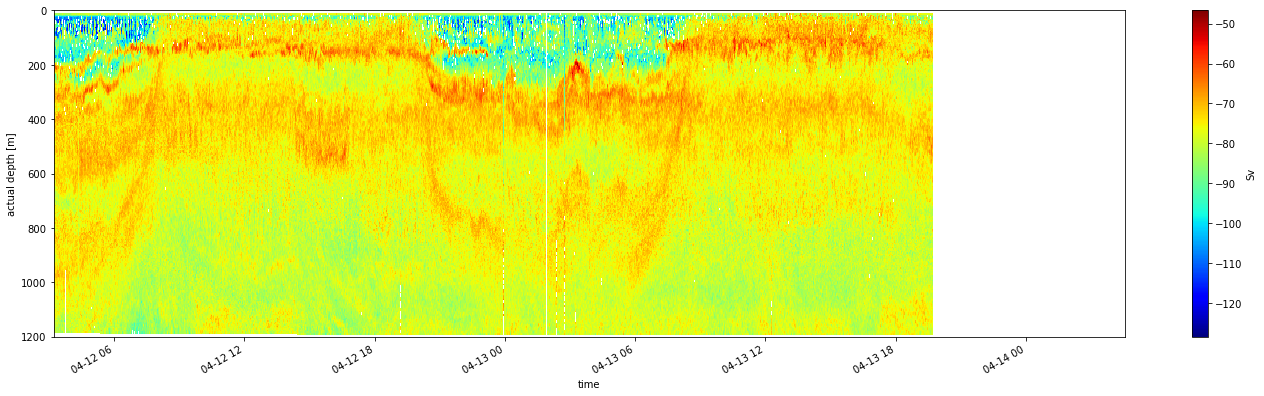

In [4]:
fig = (10*np.log10(ds.Sv)).plot(x='TIME', size=6, aspect=4, cmap="jet")
plt.gca().invert_yaxis()

# Get layers of interest

Working on one channel at a time so please select the channel first

In [5]:
ds_s = ds[['Sv']]
ds_s

<xarray.Dataset>
Dimensions:  (DEPTH: 240, TIME: 6569)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2016-04-12T03:13:47.337998848 ... 2016-04-...
  * DEPTH    (DEPTH) float64 2.5 7.5 12.5 17.5 ... 1.188e+03 1.192e+03 1.198e+03
Data variables:
    Sv       (TIME, DEPTH) float64 nan nan 1.967e-09 1.228e-10 ... nan nan nan
Attributes: (12/155)
    abstract:                                                    IMOS Bioacou...
    acknowledgement:                                             Any users of...
    author:                                                      Amy Nau
    author_email:                                                Amy.Nau@csir...
    calibration_accuracy_estimate:                               0.5
    calibration_acquisition_method:                              Standard sph...
    ...                                                          ...
    transit_end_locality:                                        46.5S 142E
    transit_start_locality:                                      50.9S 150.7E
    units:                                                       signed decim...
    uplimit:                                                     [2.5]
    westlimit:                                                   [142.02581817]
    zunits:                                                      m

## Interpolation along DEPTH axis and drop all nan slices in TIME

In [6]:
ds_s = ds_s.interpolate_na('DEPTH', method="linear", fill_value="extrapolate")
ds_s = ds_s.dropna('TIME')
ds_s

<xarray.Dataset>
Dimensions:  (DEPTH: 240, TIME: 6430)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2016-04-12T03:13:47.337998848 ... 2016-04-...
  * DEPTH    (DEPTH) float64 2.5 7.5 12.5 17.5 ... 1.188e+03 1.192e+03 1.198e+03
Data variables:
    Sv       (TIME, DEPTH) float64 5.655e-09 3.811e-09 ... 8.684e-09 1.161e-08
Attributes: (12/155)
    abstract:                                                    IMOS Bioacou...
    acknowledgement:                                             Any users of...
    author:                                                      Amy Nau
    author_email:                                                Amy.Nau@csir...
    calibration_accuracy_estimate:                               0.5
    calibration_acquisition_method:                              Standard sph...
    ...                                                          ...
    transit_end_locality:                                        46.5S 142E
    transit_start_locality:                                      50.9S 150.7E
    units:                                                       signed decim...
    uplimit:                                                     [2.5]
    westlimit:                                                   [142.02581817]
    zunits:                                                      m

/home/jovyan/my-conda-envs/bioacoustics/lib/python3.9/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


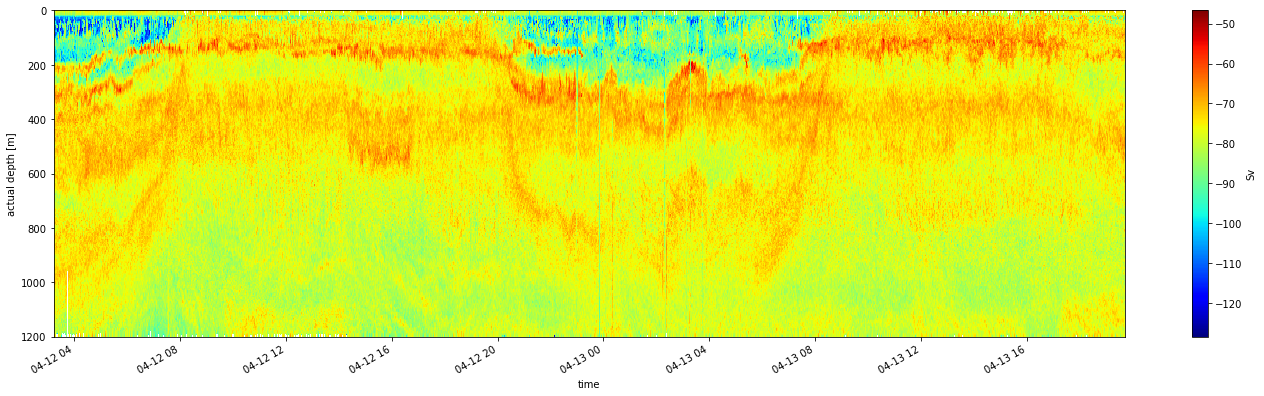

In [7]:
fig = (10*np.log10(ds_s.Sv)).plot(x='TIME', size=6, aspect=4, cmap="jet").figure
plt.gca().invert_yaxis()

In [8]:
fig.savefig('initial_img.png')

## Using mean filtering to smooth the image and remove noise

/home/jovyan/my-conda-envs/bioacoustics/lib/python3.9/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


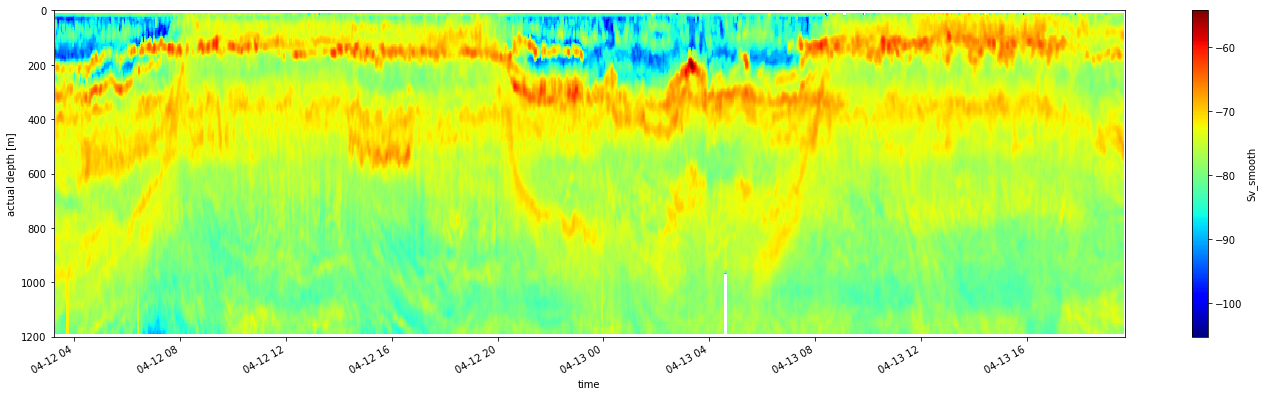

In [9]:
Sv_smooth = ds_s['Sv'].rolling(TIME=15, center=True).mean().rolling(DEPTH=5, center=True).mean()
ds_s = ds_s.assign(variables={"Sv_smooth": (('TIME', 'DEPTH'), Sv_smooth)})
(10*np.log10(ds_s.Sv_smooth)).plot(x='TIME', size=6, aspect=4, cmap="jet")
plt.gca().invert_yaxis()

# Simple thresholding using the mean

In [10]:
from skimage.filters import threshold_otsu
thresh = ds_s['Sv_smooth'].mean()# threshold_otsu(Sv_smooth.data)
thresh

<xarray.DataArray 'Sv_smooth' ()>
array(3.99221364e-08)

In [11]:
ds_s = ds_s.assign(variables={"Sv_mask": (('TIME', 'DEPTH'), (ds_s['Sv_smooth']>thresh))})
ds_s

<xarray.Dataset>
Dimensions:    (DEPTH: 240, TIME: 6430)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2016-04-12T03:13:47.337998848 ... 2016-0...
  * DEPTH      (DEPTH) float64 2.5 7.5 12.5 ... 1.188e+03 1.192e+03 1.198e+03
Data variables:
    Sv         (TIME, DEPTH) float64 5.655e-09 3.811e-09 ... 8.684e-09 1.161e-08
    Sv_smooth  (TIME, DEPTH) float64 nan nan nan nan nan ... nan nan nan nan nan
    Sv_mask    (TIME, DEPTH) bool False False False False ... False False False
Attributes: (12/155)
    abstract:                                                    IMOS Bioacou...
    acknowledgement:                                             Any users of...
    author:                                                      Amy Nau
    author_email:                                                Amy.Nau@csir...
    calibration_accuracy_estimate:                               0.5
    calibration_acquisition_method:                              Standard sph...
    ...                                                          ...
    transit_end_locality:                                        46.5S 142E
    transit_start_locality:                                      50.9S 150.7E
    units:                                                       signed decim...
    uplimit:                                                     [2.5]
    westlimit:                                                   [142.02581817]
    zunits:                                                      m

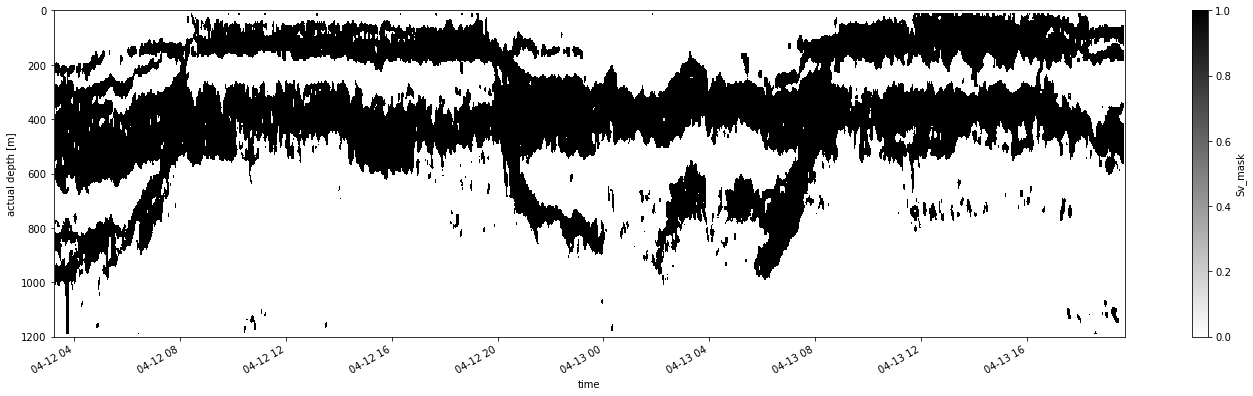

In [12]:
ds_s["Sv_mask"].plot(x='TIME', size=6, aspect=4, cmap="binary")
plt.gca().invert_yaxis()

# Edge detection

Using canny filtering to get the edges of the layers

In [13]:
from skimage import feature
edges = feature.canny(ds_s['Sv_mask'].data, sigma=11)
ds_s = ds_s.assign(variables={"edges": (('TIME', 'DEPTH'), edges)})

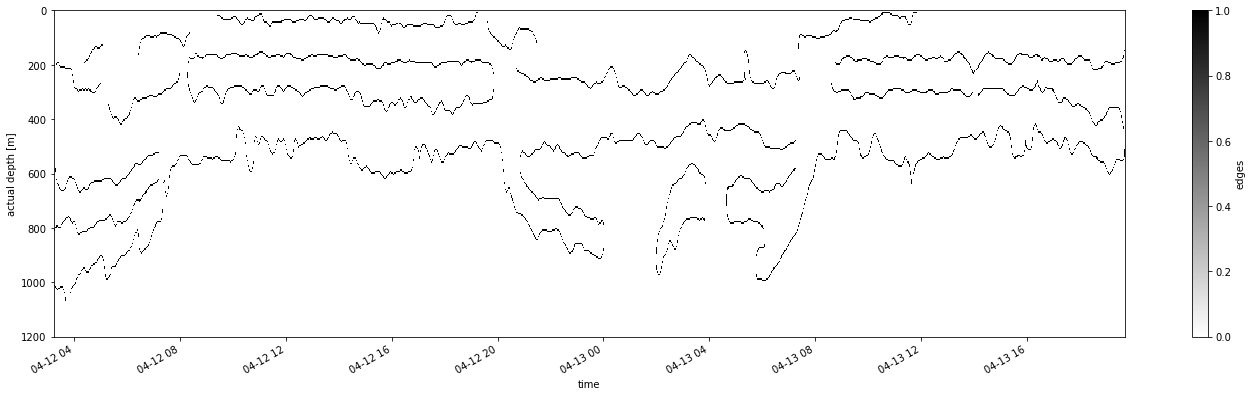

In [14]:
fig = ds_s["edges"].plot(x='TIME', size=6, aspect=4, cmap="binary").figure
plt.gca().invert_yaxis()

In [15]:
fig.savefig('contours.png')

# Apply mask on initial image

In [16]:
filtered = ds_s['Sv'].where(ds_s['Sv_mask'])
filtered

<xarray.DataArray 'Sv' (TIME: 6430, DEPTH: 240)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * TIME     (TIME) datetime64[ns] 2016-04-12T03:13:47.337998848 ... 2016-04-...
  * DEPTH    (DEPTH) float64 2.5 7.5 12.5 17.5 ... 1.188e+03 1.192e+03 1.198e+03
Attributes:
    ancillary_variables:  Sv_quality_control
    long_name:            mean_volume_backscattering_coefficient_final_data_p...
    units:                m-1
    valid_max:            [1.]
    valid_min:            [0.]

/home/jovyan/my-conda-envs/bioacoustics/lib/python3.9/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


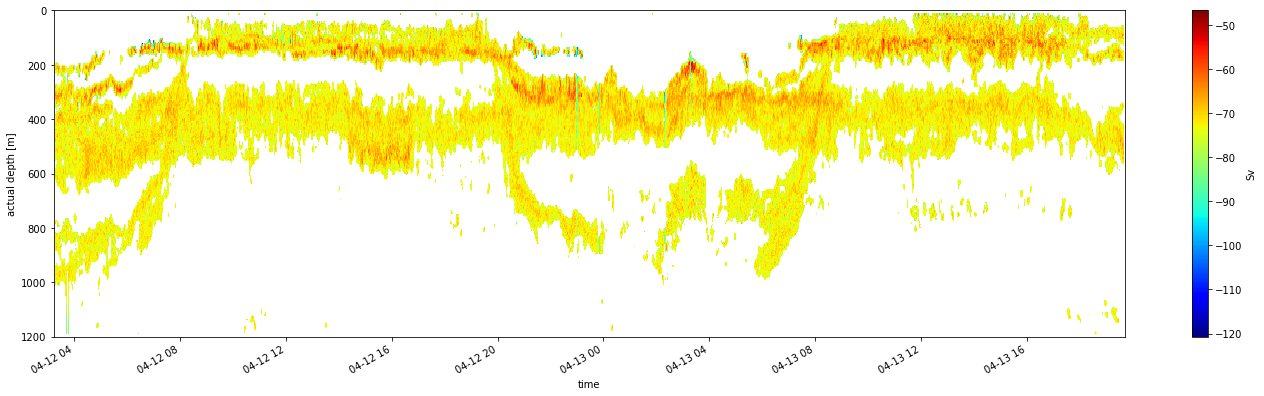

In [17]:
fig = (10*np.log10(filtered)).plot(x='TIME', size=6, aspect=4, cmap="jet").figure
plt.gca().invert_yaxis()

In [18]:
fig.savefig('mask_applied.png')

## Adding edges on the initial image

not sure how to have both overlay 

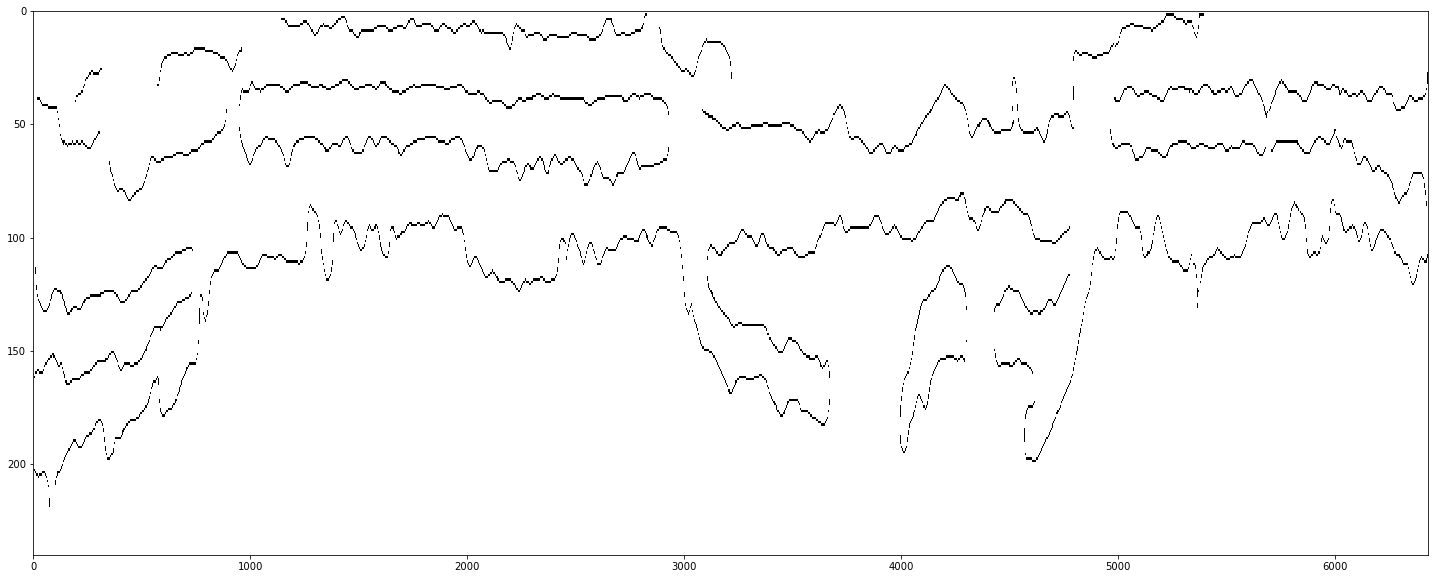

In [19]:
fig, ax = plt.subplots(figsize = (25,10))
ax.pcolormesh(10*np.log10(ds_s["Sv"]).data.T, cmap="jet")
ax.pcolormesh(ds_s['edges'].T, cmap="binary")
plt.gca().invert_yaxis()

# Other methods

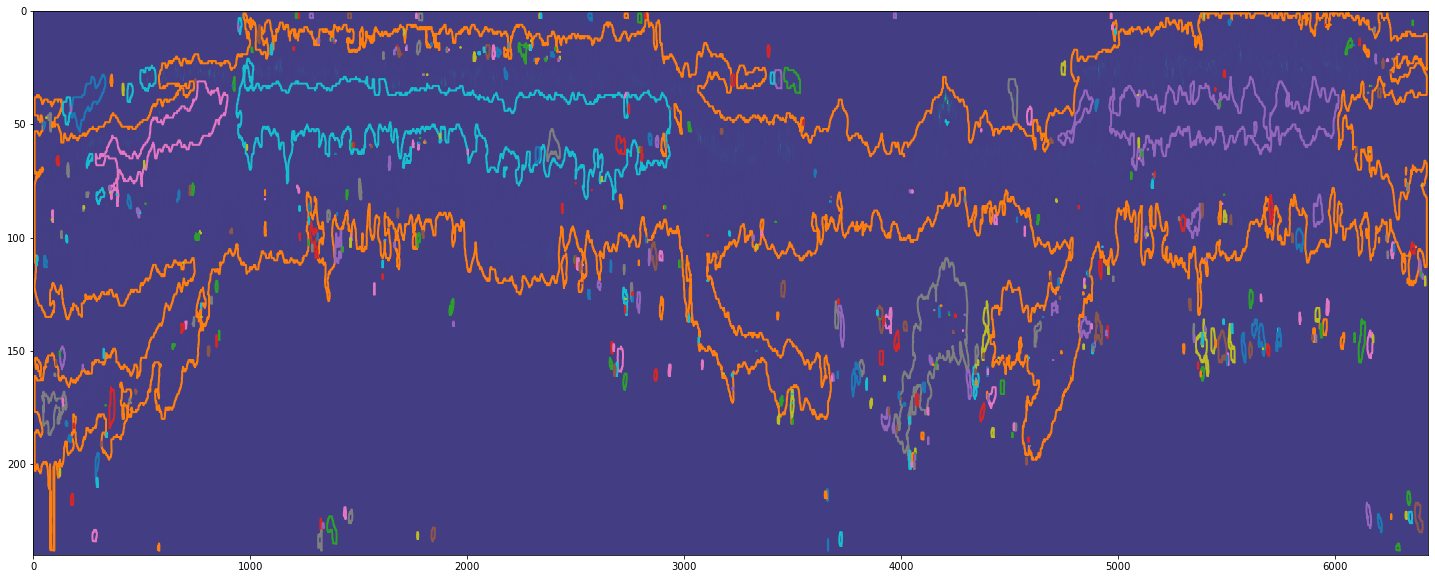

In [20]:
from skimage import measure

# Find contours at a constant value of 0.8
r = ds_s["Sv_mask"].data.T
contours = measure.find_contours(r, 0.01)

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize = (25,10))
ax.pcolormesh(ds_s["Sv"].data.T)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.invert_yaxis()
plt.show()

/tmp/ipykernel_1578/4136222135.py:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image_gray = rgb2gray(image)


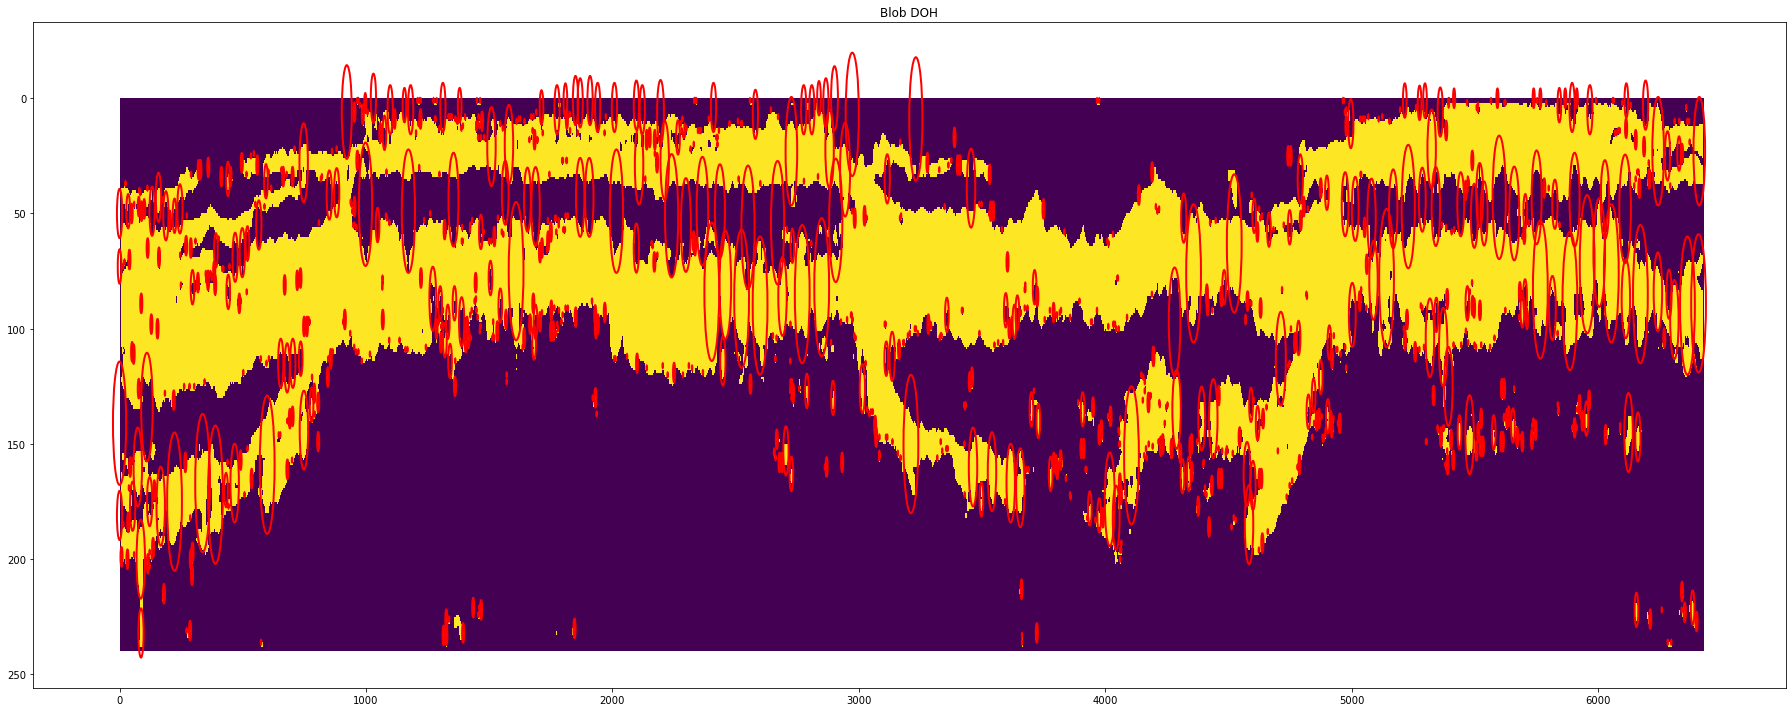

In [21]:
from math import sqrt
from skimage.feature import blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


image = ds_s['Sv_mask'].T
image_gray = rgb2gray(image)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.02)

fig, ax = plt.subplots(figsize = (25,10))
ax.set_title("Blob DOH")
ax.pcolormesh(image)
for blob in blobs_doh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Ressources to other methods

* Trained classifier (random forest): https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_trainable_segmentation.html#sphx-glr-auto-examples-segmentation-plot-trainable-segmentation-py

* Marching suqares algorithm: https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html#sphx-glr-auto-examples-edges-plot-contours-py

* Blob Determinant of Hessian method: https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_doh
